# Evaluate BERT fine-tuned model using limited training data

In [15]:
import torch

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [16]:
BASE_MODEL_NAME = "bert-base-uncased"
FINE_TUNING = True

TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 8

EPOCHS = 5
PERCENT_OF_TRAINING_DATA = 0.1
if FINE_TUNING:
    SAVED_MODEL_NAME = 'models/our-bert-finetuned-' + str(PERCENT_OF_TRAINING_DATA*100) + '-percents.sd'
else:
    SAVED_MODEL_NAME = 'models/our-bert-frozen.sd'

print(SAVED_MODEL_NAME)

models/our-bert-finetuned-10.0-percents.sd


In [17]:
# Libraries needed for data preparation
import pandas as pd
import numpy as np

# Download the dataset and put it in subfolder called data
datapath = "data/SUBJ/data.tsv"
df = pd.read_csv(datapath, sep="\t")
df = df[["text", "label"]]

In [18]:
# Renaming, Input -> X, Output -> y
X = df['text']
y = np.unique(df['label'], return_inverse=True)[1]
print(type(X))

<class 'pandas.core.series.Series'>


Let’s instantiate the BERT tokenizer.

In [19]:
from transformers import logging, AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)

Prepare the Dataset

In [20]:
# Convert data to torch tensor
X_list = X.to_list()
X_pt = tokenizer(X_list, padding='max_length', max_length = 256, truncation=True,  return_tensors='pt')["input_ids"]

y_list=y.tolist()
y_pt = torch.Tensor(y_list).long()

Let’s split the dataset into training, testing and validation data.

In [21]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

X_pt_train, X_pt_test, y_pt_train, y_pt_test = train_test_split(X_pt, y_pt, test_size=0.1, random_state=RANDOM_STATE, stratify=y_pt)
X_pt_train, X_pt_val, y_pt_train, y_pt_val = train_test_split(X_pt_train, y_pt_train, test_size=0.1, random_state=RANDOM_STATE, stratify=y_pt_train)

if PERCENT_OF_TRAINING_DATA < 1:
    X_pt_train, X_notused, y_pt_train, y_notused = train_test_split(X_pt_train, y_pt_train, test_size=(1 - PERCENT_OF_TRAINING_DATA), random_state=RANDOM_STATE, stratify=y_pt_train)


print('#train_samples:', len(y_pt_train))
print('#val_samples:', len(y_pt_val))
print('#test_samples:', len(y_pt_test))

#train_samples: 810
#val_samples: 900
#test_samples: 1000


In [22]:
# Convert data to torch dataset
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X, y as Torch tensors
        """
        self.X_train = X
        self.y_train = y
        

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]
# Get train and test data in form of Dataset class
train_data_pt = MyDataset(X=X_pt_train, y=y_pt_train)
test_data_pt = MyDataset(X=X_pt_test, y=y_pt_test)
val_data_pt = MyDataset(X=X_pt_val, y=y_pt_val)

In [23]:
# Get train and test data in form of Dataloader class
train_loader_pt = DataLoader(train_data_pt, batch_size=TRAIN_BATCH_SIZE)
test_loader_pt = DataLoader(test_data_pt, batch_size=TRAIN_BATCH_SIZE)
val_loader_pt = DataLoader(val_data_pt, batch_size=VAL_BATCH_SIZE)

**Build the Model**

In [24]:
import transformers

dbert_pt = AutoModel.from_pretrained(BASE_MODEL_NAME)

In [25]:
from torch import nn
num_classes = 2

class BertClassification(nn.Module):
    def __init__(self):
        super(BertClassification, self).__init__()
        self.dbert = dbert_pt
        self.num_classes = 2
        self.linear = nn.Linear(dbert_pt.config.hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.5)
        # BERT model is trainable
        if FINE_TUNING:
            for param in dbert_pt.parameters():
                param.requires_grad_(True)
        else:
            for param in dbert_pt.parameters():
                param.requires_grad_(False)

    def forward(self, x):
        x = self.dbert(input_ids=x)
        x = x["last_hidden_state"][:,0,:]
        x = self.dropout(x)
        x = self.linear(x)
        return x

In [26]:
model_pt = BertClassification().to(device)

In [27]:
total_params = sum(p.numel() for p in model_pt.parameters())
total_params_trainable = sum(p.numel() for p in model_pt.parameters() if p.requires_grad)
print("Number of parameters: ", total_params)
print("Number of trainable parameters: ", total_params_trainable)

Number of parameters:  109483778
Number of trainable parameters:  109483778


**Train the Model**

In [28]:
from datetime import datetime


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_pt.parameters(), lr=1e-5, weight_decay=0.01)
from tqdm import tqdm
# Define the dictionary "history" that will collect key performance indicators during training
history = {}
history["epoch"]=[]
history["train_loss"]=[]
history["valid_loss"]=[]
history["train_accuracy"]=[]
history["valid_accuracy"]=[]

# Measure time for training
start_time = datetime.now()

# Loop on epochs
for e in range(EPOCHS):
    
    # Set mode in train mode
    model_pt.train()
    
    train_loss = 0.0
    train_accuracy = []
    
    # Loop on batches
    for X, y in tqdm(train_loader_pt):
        X = X.to(device)
        y = y.to(device)
        # Get prediction & loss
        # print(X.is_cuda)
        # print(y.is_cuda)
        prediction = model_pt(X)
       
        loss = criterion(prediction, y)
        
        # Adjust the parameters of the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        prediction_index = prediction.argmax(axis=1)
        accuracy = (prediction_index==y)
        train_accuracy += accuracy
    
    train_accuracy = (sum(train_accuracy) / len(train_accuracy)).item()
    # Calculate the loss on the test data after each epoch
    # Set mode to evaluation (by opposition to training)
    model_pt.eval()
    valid_loss = 0.0
    valid_accuracy = []
    for X, y in val_loader_pt:
        X = X.to(device)
        y = y.to(device)  
        prediction = model_pt(X)
        loss = criterion(prediction, y)

        valid_loss += loss.item()
        
        prediction_index = prediction.argmax(axis=1)
        accuracy = (prediction_index==y)
        valid_accuracy += accuracy
    valid_accuracy = (sum(valid_accuracy) / len(valid_accuracy)).item()

    # Populate history
    history["epoch"].append(e+1)
    history["train_loss"].append(train_loss / len(train_loader_pt))
    history["valid_loss"].append(valid_loss / len(test_loader_pt))
    history["train_accuracy"].append(train_accuracy)
    history["valid_accuracy"].append(valid_accuracy)    
        
    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_loader_pt) :10.3f} \t\t Validation Loss: {valid_loss / len(test_loader_pt) :10.3f}')
    print(f'\t\t Training Accuracy: {train_accuracy :10.3%} \t\t Validation Accuracy: {valid_accuracy :10.3%}')

# Measure time for training
end_time = datetime.now()
training_time_pt = (end_time - start_time).total_seconds()

100%|██████████| 102/102 [00:17<00:00,  5.97it/s]


Epoch 1 		 Training Loss:      0.721 		 Validation Loss:      0.614
		 Training Accuracy:    50.000% 		 Validation Accuracy:    50.000%


100%|██████████| 102/102 [00:17<00:00,  5.95it/s]


Epoch 2 		 Training Loss:      0.422 		 Validation Loss:      0.197
		 Training Accuracy:    78.765% 		 Validation Accuracy:    91.778%


100%|██████████| 102/102 [00:17<00:00,  5.90it/s]


Epoch 3 		 Training Loss:      0.177 		 Validation Loss:      0.164
		 Training Accuracy:    93.704% 		 Validation Accuracy:    94.778%


100%|██████████| 102/102 [00:17<00:00,  5.89it/s]


Epoch 4 		 Training Loss:      0.094 		 Validation Loss:      0.163
		 Training Accuracy:    96.420% 		 Validation Accuracy:    94.778%


100%|██████████| 102/102 [00:17<00:00,  5.95it/s]


Epoch 5 		 Training Loss:      0.021 		 Validation Loss:      0.211
		 Training Accuracy:    99.506% 		 Validation Accuracy:    94.333%


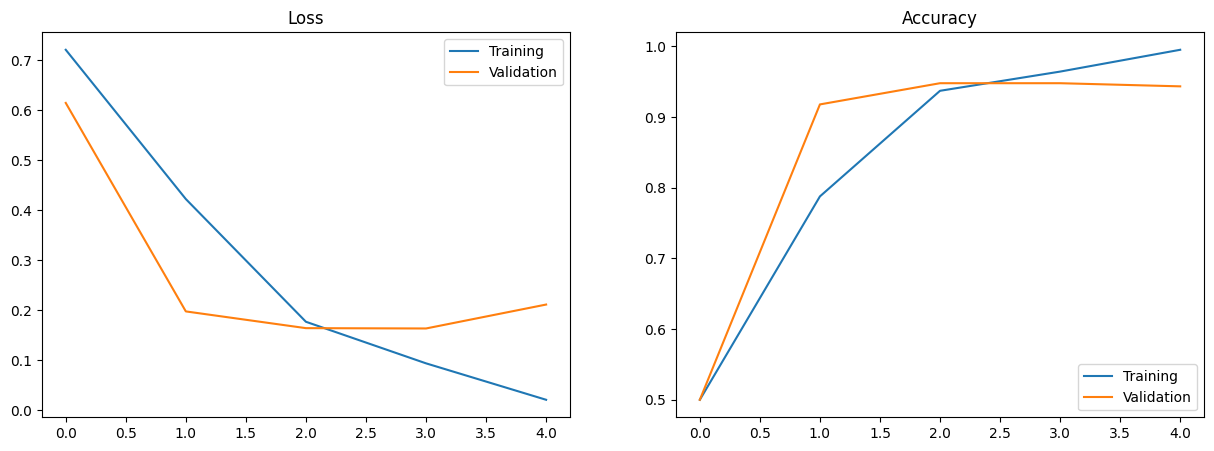

In [29]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history['train_loss'], label='Training')
ax[0].plot(history['valid_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history['train_accuracy'], label='Training')
ax[1].plot(history['valid_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

**Evaluate the Model**

In [30]:
# Evaluate the model on the test set
def evaluate_model(model_pt, dataloader):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    valid_accuracy = []
    valid_loss = 0.0
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device) 
        prediction = model_pt(X)
        loss = criterion(prediction, y)

        valid_loss += loss.item()
            
        prediction_index = prediction.argmax(axis=1)
        accuracy = (prediction_index==y)
        
        label_list = y.tolist()
        predicted_label_list = prediction_index.tolist()

        for i in range(len(label_list)):
            if label_list[i] == 1:
                if predicted_label_list[i] == 1:
                    TP += 1
                else:
                    FN += 1
            else:
                if predicted_label_list[i] == 0:
                    TN += 1
                else:
                    FP += 1
                # print(label_list,'-->', predicted_label_list)
        valid_accuracy += accuracy
    valid_accuracy = (sum(valid_accuracy) / len(valid_accuracy)).item()
    print(valid_accuracy)
    print('TP:', TP)
    print('FN:', FN)
    print('FP:', FP)
    print('TN:', TN)

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 2 * precision * recall / (precision + recall)
    # print('accracy:', total_acc / total_count)
    print('precision:', precision)
    print('recall:', recall)
    print('F1:', F1)
    print('{:10.4f},{:10.4f},{:10.4f},{:10.4f}'.format(valid_accuracy, precision, recall, F1))

In [31]:
evaluate_model(model_pt, test_loader_pt)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 7.78 GiB of which 39.06 MiB is free. Including non-PyTorch memory, this process has 7.48 GiB memory in use. Of the allocated memory 6.52 GiB is allocated by PyTorch, and 243.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

**Save the Model**

In [ ]:
# Save only the parameters of the model but not the model itself, and get it back
torch.save(model_pt.state_dict(), SAVED_MODEL_NAME)